<a href="https://colab.research.google.com/github/promedius/tutorial/blob/master/stylegan2ada_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

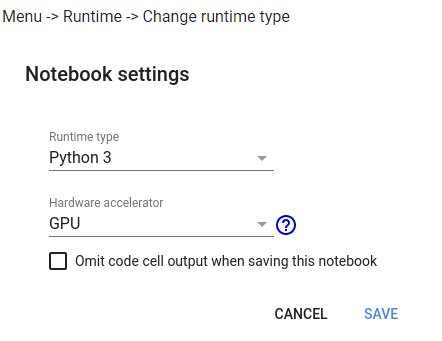

In [1]:
#할당된 gpu 확인
!nvidia-smi

# 런타임 유형을 GPU로 설정하지 않으면 아래 문구가 뜸
#NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Sat Aug 14 04:42:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#현재 경로에 있는 파일이 무엇이 있는지 확인해보기(아래 코드를 받고 난 후와 비교)
!ls

In [2]:
# stylegan2-ada pytorch 공개 코드 가져오기
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 2.99 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [6]:
#가져온 코드 확인하기
!ls

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


In [5]:
#작업 위치를 코드 아래와 옮기기
import os
os.chdir('./stylegan2-ada-pytorch/')

FileNotFoundError: ignored

In [7]:
#필요한 파이썬 라이브러리 설치하기
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     |████████████████████████████████| 195 kB 6.4 MB/s 
     |████████████████████████████████| 108 kB 66.5 MB/s 
     |████████████████████████████████| 26.9 MB 85 kB/s 


In [8]:
#필요한 라이브러리 불러오기
import torch
torch.cuda.device_count()
import torchvision

In [27]:
#핸즈온에 필요한 데이터 가져오기(데이터 권한: 프로메디우스(주)의 데이터이며, 본 핸즈온용으로 무료 배포)
!wget https://drive.promedius.dev/s/yckg33p7CGedRcW/download/handson_data_GAN.zip
!wget https://drive.promedius.dev/s/6G3HyqSLLMa3ifM/download/weight_and_samples.zip

--2021-08-14 05:14:59--  https://drive.promedius.dev/s/6G3HyqSLLMa3ifM/download/weight_and_samples.zip
Resolving drive.promedius.dev (drive.promedius.dev)... 121.167.54.100
Connecting to drive.promedius.dev (drive.promedius.dev)|121.167.54.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579780678 (553M) [application/zip]
Saving to: ‘weight_and_samples.zip’

weight_and_samples. 100%[===================>] 552.92M  8.99MB/s    in 2m 0s   

2021-08-14 05:17:00 (4.61 MB/s) - ‘weight_and_samples.zip’ saved [579780678/579780678]



In [28]:
#받은 데이터 확인하기
!ls

calc_metrics.py  generate.py	       projector.py	training
dataset_tool.py  handson_data_GAN      __pycache__	train.py
dnnlib		 handson_data_GAN.zip  README.md	weight_and_samples.zip
Dockerfile	 legacy.py	       results
docker_run.sh	 LICENSE.txt	       style_mixing.py
docs		 metrics	       torch_utils


In [29]:
#데이터 압축풀기(총 4200장의 흉부 X-ray이미지이며 인공지능 생성모델로 만든 합성이미지임)
!unzip handson_data_GAN.zip
!unzip weight_and_samples.zip

Archive:  weight_and_samples.zip
   creating: weight_and_samples/
   creating: weight_and_samples/cyclegan/
   creating: weight_and_samples/cyclegan/weight/
  inflating: weight_and_samples/cyclegan/weight/latest_net_G.pth  
  inflating: weight_and_samples/cyclegan/weight/latest_net_G_A.pth  
  inflating: weight_and_samples/cyclegan/weight/latest_net_G_B.pth  
   creating: weight_and_samples/stylegan/
   creating: weight_and_samples/stylegan/sample_images/
  inflating: weight_and_samples/stylegan/sample_images/fakes000000.png  
  inflating: weight_and_samples/stylegan/sample_images/fakes000040.png  
  inflating: weight_and_samples/stylegan/sample_images/fakes000161.png  
  inflating: weight_and_samples/stylegan/sample_images/fakes000322.png  
  inflating: weight_and_samples/stylegan/sample_images/fakes000403.png  
  inflating: weight_and_samples/stylegan/sample_images/fakes000604.png  
   creating: weight_and_samples/stylegan/weight/
  inflating: weight_and_samples/stylegan/weight/netwo

In [30]:
#압축이 잘 풀렸는지 확인
!ls

calc_metrics.py  generate.py	       projector.py	training
dataset_tool.py  handson_data_GAN      __pycache__	train.py
dnnlib		 handson_data_GAN.zip  README.md	weight_and_samples
Dockerfile	 legacy.py	       results		weight_and_samples.zip
docker_run.sh	 LICENSE.txt	       style_mixing.py
docs		 metrics	       torch_utils


In [15]:
imglist=os.listdir('handson_data_GAN/promedius_cxr_2000_for_stylegan2ada')#이미지 파일명을 imglist라는 변수에 담기
print(len(imglist))#이미지 개수 확인
print(imglist[:10])#샘플로 10개 이미지 파일명 확인

2000
['promedius_synthesized_cxr_001492.png', 'promedius_synthesized_cxr_001633.png', 'promedius_synthesized_cxr_000659.png', 'promedius_synthesized_cxr_000899.png', 'promedius_synthesized_cxr_001467.png', 'promedius_synthesized_cxr_001545.png', 'promedius_synthesized_cxr_001520.png', 'promedius_synthesized_cxr_001276.png', 'promedius_synthesized_cxr_001392.png', 'promedius_synthesized_cxr_001309.png']


In [ ]:
#샘플 이미지 10장을 디스플레이해보기
import cv2
import matplotlib.pyplot as plt

for tmp in range(10):
  img=cv2.imread(os.path.join('handson_data_GAN/promedius_cxr_2000_for_stylegan2ada', imglist[tmp]), 0)#이미지 읽기
  plt.figure(figsize=(5,5))
  print(imglist[tmp])#이미지 파일명 출력하기
  plt.imshow(img, cmap='gray')#이미지 디스플레이하기
  plt.show()

In [20]:
!ls

calc_metrics.py  docs		       LICENSE.txt	torch_utils
dataset_tool.py  generate.py	       metrics		training
dnnlib		 handson_data_GAN      projector.py	train.py
Dockerfile	 handson_data_GAN.zip  README.md
docker_run.sh	 legacy.py	       style_mixing.py


In [21]:
# 총 2000장의 이미지 중에서 500장만 랜덤으로 가져옴(학습에 사용할 데이터. 2000장은  Colab으로 돌리기가 무거워서 500장으로 줄임)
import random
import shutil

random.shuffle(imglist) #총 2000장의 이미지 랜덤으로 섞기
imglist_500_sampled=imglist[:500] #랜덤으로 섞은 이미지 리스트중에 500장 이미지에 대한 파일명을 imglist_500_sampled라는 변수에 저장하기
os.makedirs('handson_data_GAN/promedius_cxr_500_for_stylegan2ada')#500장 이미지를 옮길 폴더 만들기

#500장 폴더를 새로운 폴더로 옮기기
for tmp in range(len(imglist_500_sampled)):
  shutil.copy(os.path.join('handson_data_GAN/promedius_cxr_2000_for_stylegan2ada', imglist_500_sampled[tmp]), 'handson_data_GAN/promedius_cxr_500_for_stylegan2ada')

In [23]:
#새로 만들어진 폴더 확인하기
!ls handson_data_GAN

promedius_cxr_2000_for_cyclegan      promedius_cxr_500_for_stylegan2ada
promedius_cxr_2000_for_stylegan2ada


In [24]:
#Stylegan2ada에 맞는 입력 포맷으로 변환하기
!python dataset_tool.py --source=handson_data_GAN/promedius_cxr_500_for_stylegan2ada --dest=handson_data_GAN/promedius_cxr_500_for_stylegan2ada.zip

100% 500/500 [00:02<00:00, 182.14it/s]


In [25]:
#새로 만들어진 파일 확인하기
!ls handson_data_GAN

promedius_cxr_2000_for_cyclegan      promedius_cxr_500_for_stylegan2ada
promedius_cxr_2000_for_stylegan2ada  promedius_cxr_500_for_stylegan2ada.zip


In [26]:
#생성모델 학습하기
!python train.py --outdir=./results --data=handson_data_GAN/promedius_cxr_500_for_stylegan2ada.zip --gpus=1 --augpipe=bg --gamma=10 --cfg=paper256 --mirror=1 --snap=10 --metrics=none --resume=ffhq256 


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "handson_data_GAN/promedius_cxr_500_for_stylegan2ada.zip",
    "use_labels": false,
    "max_size": 500,
    "xflip": true,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 8
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 8
    },
    "channel_base": 16384,
    "channel_

###작업 로그 및 학습도중 저장된 모델 weight 확인해보기

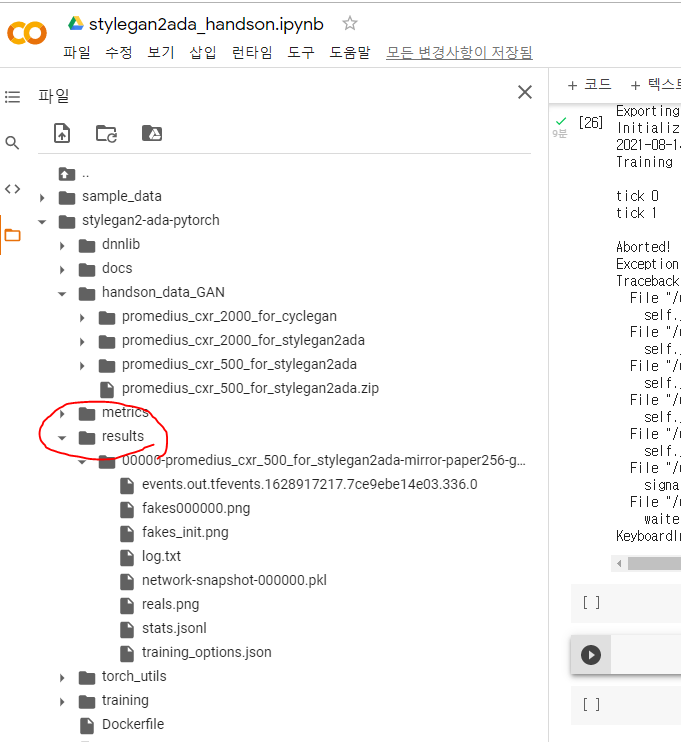

###학습이 진행되면 아래와 같이 로그가 남음

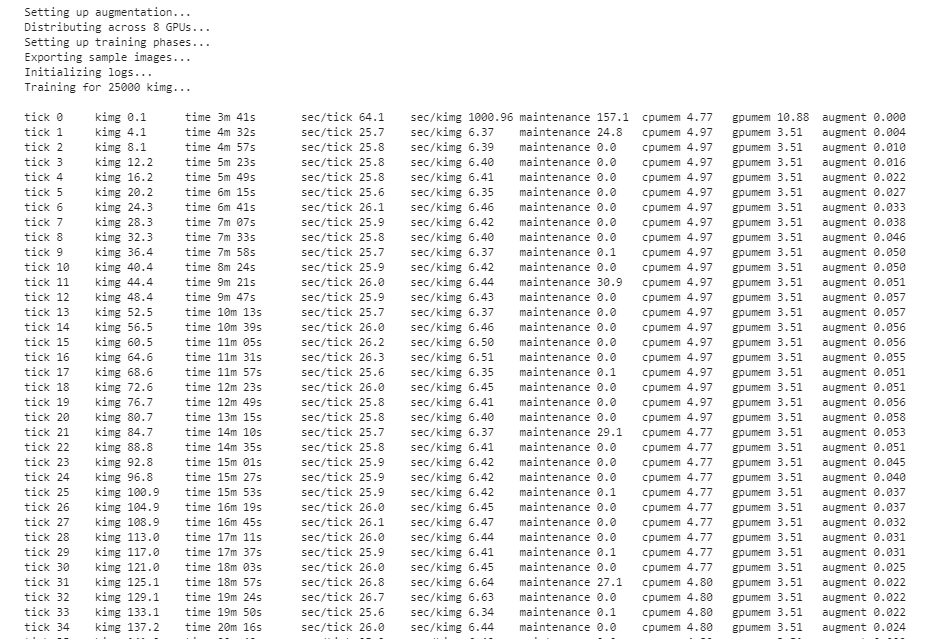

In [43]:
#미리 학습해둔 weight로 합성 이미지 만들기(trunc: 합성 이미지의 분포 넓이)
!python generate.py --outdir generated_images --trunc=1 --seeds=10 --network 'weight_and_samples/stylegan/weight/network-snapshot-000604.pkl'

Loading networks from "weight_and_samples/stylegan/weight/network-snapshot-000604.pkl"...
Generating image for seed 10 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [44]:
#합성한 이미지 파일 체크해보기
os.listdir('generated_images')

['seed0010.png']

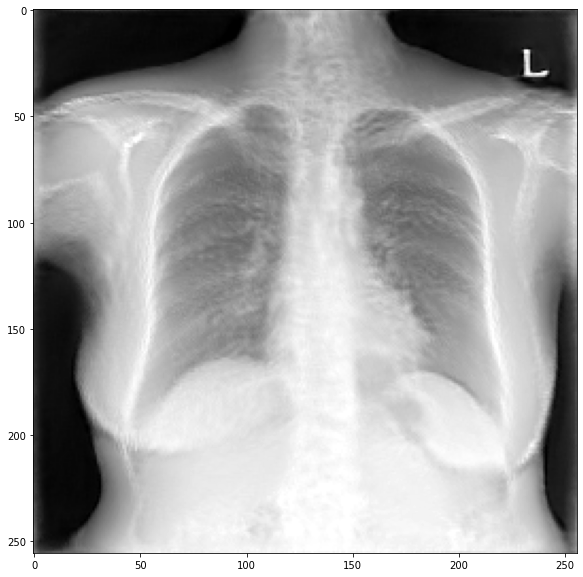

In [46]:
#합성한 이미지 디스플레이 해보기(참고: 학습이 충분히 되지 않음. 1024x1024-pixel 이미지를 생성시 StyleGAN2-ADA의 경우 GPU 24GB하나를 사용했을때 대략 2주일 정도 소요됨)
syn_img=cv2.imread('generated_images/seed0010.png', 0)
plt.figure(figsize=(10,10))
plt.imshow(syn_img, cmap='gray')
plt.show()